In [24]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus

user = "root"
password = quote_plus("Yangsijie0819$")  # 避免密码里有 @ : / 等特殊字符导致连接串坏掉
host = "127.0.0.1"
port = 3306
db = "aidev"

engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8mb4",
    pool_pre_ping=True,
)


In [25]:
with engine.connect() as conn:
    print(conn.exec_driver_sql("SELECT 1").fetchone())


(1,)


In [26]:
from pathlib import Path

DATA_DIR = Path("/Users/young/Downloads/MDS/M3/542 data wrangling/data")


In [27]:

tables = [
    "pull_request",
    "pr_comments",
    "pr_reviews",
    "pr_review_comments_v2",
    "pr_commits",
    "pr_timeline",
    "user",
]
name_map = {"user": "aidev_user"}

DROP_COLS = {
    "body", "diff", "patch", "description", "message", "text", "content",
    "diff_hunk", "hunk", "raw_diff", "raw_patch", "code", "snippet"
}


for t in tables:
    path = DATA_DIR / f"{t}.parquet"
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")

    df = pd.read_parquet(path)
    df = df.drop(columns=[c for c in df.columns if c in DROP_COLS], errors="ignore")

    print("\n===", t, "===")
    print("path:", path)
    print("shape:", df.shape)
    print("first_cols:", df.columns.tolist()[:20])

    df.to_sql(
        name_map.get(t, t),
        con=engine,
        if_exists="replace",
        index=False,
        chunksize=50_000,
        method="multi",
    )

print("Import done.")



=== pull_request ===
path: /Users/young/Downloads/MDS/M3/542 data wrangling/data/pull_request.parquet
shape: (33596, 13)
first_cols: ['id', 'number', 'title', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url']

=== pr_comments ===
path: /Users/young/Downloads/MDS/M3/542 data wrangling/data/pr_comments.parquet
shape: (39122, 6)
first_cols: ['id', 'pr_id', 'user', 'user_id', 'user_type', 'created_at']

=== pr_reviews ===
path: /Users/young/Downloads/MDS/M3/542 data wrangling/data/pr_reviews.parquet
shape: (28875, 6)
first_cols: ['id', 'pr_id', 'user', 'user_type', 'state', 'submitted_at']

=== pr_review_comments_v2 ===
path: /Users/young/Downloads/MDS/M3/542 data wrangling/data/pr_review_comments_v2.parquet
shape: (26868, 13)
first_cols: ['id', 'pull_request_review_id', 'user', 'user_type', 'path', 'position', 'original_position', 'commit_id', 'original_commit_id', 'pull_request_url', 'created_at', 'updated_at', 'in_reply_to_i

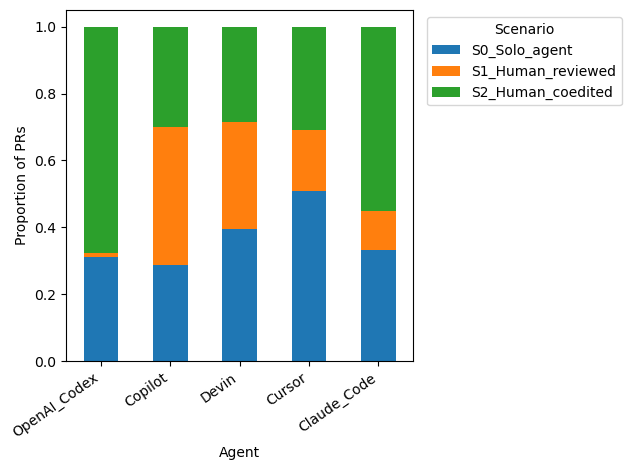

In [29]:

import matplotlib.pyplot as plt


df = pd.read_sql("""
SELECT agent, scenario_label, COUNT(*) AS n
FROM pr_scenarios_rq1
GROUP BY agent, scenario_label;
""", engine)

pivot = df.pivot(index="agent", columns="scenario_label", values="n").fillna(0)

# 让列顺序固定（保证颜色一致）
cols = ["S0_Solo_agent", "S1_Human_reviewed", "S2_Human_coedited"]
pivot = pivot[cols]

# 按 agent 总量排序（也可以改成按 S2 占比）
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

share = pivot.div(pivot.sum(axis=1), axis=0)

ax = share.plot(kind="bar", stacked=True)
ax.set_ylabel("Proportion of PRs")
ax.set_xlabel("Agent")

# legend 放图外
ax.legend(title="Scenario", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()
